# Algoritmo de treinamento de uma rede neural para classificação de expressões faciais

### 1 - Importações

In [2]:
import cv2
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, Activation, Add, Input, AveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
# caminho para o arquivo zip contendo os dados
zip_file_path = '/content/drive/MyDrive/dataset.zip'
# diretório de destino para extrair os dados
extracted_dir_path = '/content/datasetNormal'

import zipfile
import os

# Extrair o arquivo zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

# Listar os arquivos no diretório de extração
extracted_files = os.listdir(extracted_dir_path)
print(f'Arquivos extraídos: {extracted_files}')

Arquivos extraídos: ['test', 'train']


### 2 - Preparando o DATASET

Os trechos de códigos abaixo são responsáveis por carregar as imagens do conjunto de dados FER-2013 e prepará-las para treinar um modelo de aprendizado de máquina.

In [14]:
import numpy as np
import os, sys
from scipy import ndimage
import cv2
import matplotlib.pyplot as plt
import itertools
import scipy.stats
import tensorflow as tf
from keras import applications, optimizers, Input
from keras.models import Sequential, Model
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.multiclass import unique_labels

folder = '/content/datasetNormal/train'
print(folder)

image_width = 48
image_height = 48
channels = 1

train_files = []
i=0
for emotion in ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']:
    onlyfiles = [f for f in os.listdir(os.path.join(folder, emotion)) if os.path.isfile(os.path.join(folder, emotion, f))]
    for _file in onlyfiles:
        train_files.append(_file)

dataset = np.ndarray(shape=(len(train_files), image_height, image_width, channels),
                     dtype=np.float32)
y_dataset = []

i = 0
for emotion in ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']:
    onlyfiles = [f for f in os.listdir(os.path.join(folder, emotion)) if os.path.isfile(os.path.join(folder, emotion, f))]
    for _file in onlyfiles:
        img_path = os.path.join(folder, emotion, _file)
        img = load_img(img_path, target_size=(image_height, image_width), color_mode='grayscale')
        x = img_to_array(img)
        dataset[i] = x
        mapping = {'angry': 0 , 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
        y_dataset.append(mapping[emotion])
        i += 1
        if i == 30000:
            print("%d images to array" % i)
            break

print("All images to array!")

/content/datasetNormal/train
All images to array!


In [15]:
# normalize
dataset = dataset.astype('float32')
dataset /= 255

#### 2.1 - Impressão de exemplos tirados do DATASET

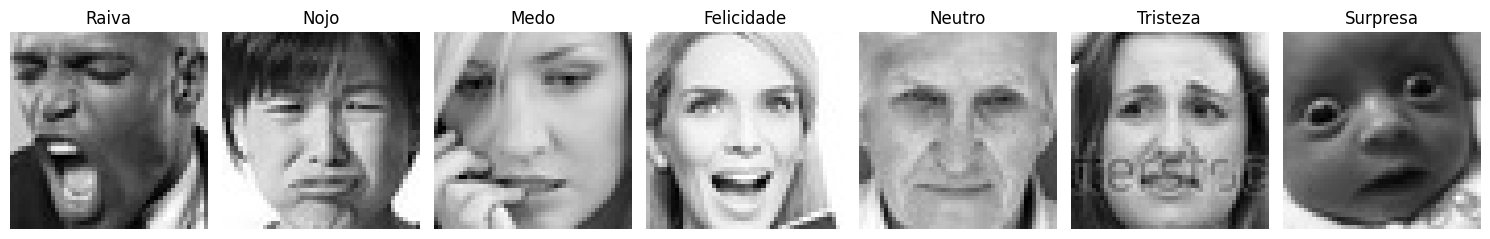

In [32]:
import matplotlib.pyplot as plt

classes = ['Raiva', 'Nojo', 'Medo', 'Felicidade', 'Neutro', 'Tristeza', 'Surpresa']

# Dicionário para armazenar o índice da primeira imagem de cada classe
first_image_index = {}

# Encontra o índice da primeira imagem de cada classe
for i, label in enumerate(y_dataset):
    if label not in first_image_index:
        first_image_index[label] = i

# Configura a grade para exibir as imagens
num_classes = len(set(y_dataset))
num_images_per_class = 1
num_cols = num_classes
num_rows = num_images_per_class

# Cria uma figura com uma grade de subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5))

# Loop através de cada classe
for i in range(num_classes):
    # Obtém o índice da primeira imagem da classe
    idx = first_image_index[i]

    # Obtém a imagem e converte para RGB
    pixels = dataset[idx].reshape(image_height, image_width)

    # Exibe a imagem no subplot correspondente
    axes[i].imshow(pixels, cmap='gray')
    axes[i].axis('off')

    # Adiciona um título para o subplot com o rótulo
    axes[i].set_title(f'{classes[i]}')

# Exibe a figura
plt.tight_layout()
plt.show()


#### 2.2 - Normalização do DATASET

Os trechos de código abaixo tem como função normalizar as imagens vindas do DATASET, para que todas as classes de emoções tenham quantidades iguais de exemplos.

In [16]:
# categorical values
n_classes = len(set(y_dataset))
print(n_classes)

y_dataset_ = to_categorical(y_dataset, n_classes)

7


In [17]:
# Trim dataset to match the size of y_dataset_
dataset_trimmed = dataset[:len(y_dataset_)]

# Now both dataset_trimmed and y_dataset_ have the same size
# You can then proceed with splitting or any other operations

# Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(dataset_trimmed, y_dataset_, test_size=0.2)

print("Train set size: {0}, Test set size: {1}".format(len(X_train), len(X_test)))

Train set size: 22967, Test set size: 5742


In [18]:
from sklearn.utils import resample

# Criar listas vazias para armazenar as amostras balanceadas
balanced_X_train = []
balanced_y_train = []

# Determinar o número de amostras na classe majoritária
majority_samples = 7000

# Iterar sobre cada classe
for class_label in np.unique(y_train.argmax(axis=1)):
    # Filtrar amostras pertencentes a essa classe
    X_class = X_train[y_train.argmax(axis=1) == class_label]
    y_class = y_train[y_train.argmax(axis=1) == class_label]

    # Calcular o número de amostras na classe menos representada
    minority_samples = len(X_class)

    # Balancear as amostras aumentando a classe menos representada
    balanced_X_class, balanced_y_class = resample(X_class, y_class,
                                                  replace=True,
                                                  n_samples=majority_samples,
                                                  random_state=42)

    # Adicionar amostras balanceadas à lista
    balanced_X_train.extend(balanced_X_class)
    balanced_y_train.extend(balanced_y_class)

# Converter listas em arrays numpy
balanced_X_train = np.array(balanced_X_train)
balanced_y_train = np.array(balanced_y_train)

# Embaralhar amostras
shuffled_indices = np.arange(len(balanced_X_train))
np.random.shuffle(shuffled_indices)
balanced_X_train = balanced_X_train[shuffled_indices]
balanced_y_train = balanced_y_train[shuffled_indices]

# Verificar o tamanho dos conjuntos de dados balanceados
print("Tamanho do conjunto de treinamento balanceado:", len(balanced_X_train))
print("Tamanho do conjunto de teste:", len(X_test))

for class_label in np.unique(balanced_y_train.argmax(axis=1)):
    count = np.sum(balanced_y_train.argmax(axis=1) == class_label)
    print(f"Classe {class_label}: {count} amostras")


Tamanho do conjunto de treinamento balanceado: 49000
Tamanho do conjunto de teste: 5742
Classe 0: 7000 amostras
Classe 1: 7000 amostras
Classe 2: 7000 amostras
Classe 3: 7000 amostras
Classe 4: 7000 amostras
Classe 5: 7000 amostras
Classe 6: 7000 amostras


### 3 - Construindo o modelo

Treinamento de um modelo de rede neural convolucional (CNN) para classificação de imagens

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization

# Criar o modelo
model = Sequential()

model.add(BatchNormalization(input_shape=(image_height, image_width, 1)))
model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))  # Adiciona a camada de dropout

model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))  # Adiciona a camada de dropout

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))  # Adiciona a camada de dropout

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))  # Adiciona a camada de dropout

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))  # Adiciona a camada de dropout
model.add(Dense(7, activation='softmax'))  # Especifica 'softmax' como a função de ativação


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 48, 48, 1)         4         
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 512)       5120      
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 512)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 512)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 256)       1179904   
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 256)       0

### 4 - Compilando o modelo

In [ ]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

### 5 - Treinamento do modelo

In [ ]:

# Treinando o modelo
from tensorflow.keras.callbacks import EarlyStopping

# Configurar EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

# Treinar o modelo
history = model.fit(balanced_X_train, balanced_y_train,validation_split= 0.2, epochs=150, callbacks=[early_stopping], batch_size=64)

Epoch 1/150
875/875 [==============================] - 76s 70ms/step - loss: 1.7003 - accuracy: 0.3182 - val_loss: 1.2757 - val_accuracy: 0.5213
Epoch 2/150
875/875 [==============================] - 64s 73ms/step - loss: 1.2796 - accuracy: 0.5102 - val_loss: 1.0456 - val_accuracy: 0.6078
Epoch 3/150
875/875 [==============================] - 61s 70ms/step - loss: 1.1179 - accuracy: 0.5700 - val_loss: 0.9509 - val_accuracy: 0.6386
Epoch 4/150
875/875 [==============================] - 61s 69ms/step - loss: 1.0393 - accuracy: 0.6010 - val_loss: 0.8861 - val_accuracy: 0.6795
Epoch 5/150
875/875 [==============================] - 63s 72ms/step - loss: 0.9684 - accuracy: 0.6307 - val_loss: 0.8117 - val_accuracy: 0.6961
Epoch 6/150
875/875 [==============================] - 61s 69ms/step - loss: 0.9214 - accuracy: 0.6507 - val_loss: 0.7625 - val_accuracy: 0.7249
Epoch 7/150
875/875 [==============================] - 63s 72ms/step - loss: 0.8766 - accuracy: 0.6683 - val_loss: 0.7201 - val_ac

#### 5.1 - Salvando o modelo e os resultados

In [ ]:
import pandas as pd
history_salvo = pd.DataFrame(history.history)
history_salvo.to_csv('history_salvo90valAcc.csv')

In [ ]:
# save model structure in jason file
model_json = model.to_json()
with open("emotion_modelcnn90valAcc.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
model.save('modelo_cnn90valAcc.h5')

#### 5.2 - Carregando o modelo e os resultados

In [5]:
from keras.models import load_model

modelo_carregado = load_model('/content/drive/MyDrive/modelo_cnn90valAcc..h5')

In [6]:
import pandas as pd

# Carregar o histórico de treinamento de um arquivo CSV
history = pd.read_csv('/content/drive/MyDrive/history_salvo90valAcc..csv')


#### 5.3 - Imprimindo o resultado da acurácia de validação do treinamento

In [ ]:
# Acessar a lista de valores de validação de acurácia no histórico
val_accuracy = history.history['val_accuracy']

# Calcular a média da validação de acurácia
mean_val_accuracy = np.mean(val_accuracy)

print("Média da validação de acurácia:", mean_val_accuracy)

Média da validação de acurácia: 0.9040288329124451


### 6 - Desenhando o gráfico da função perda

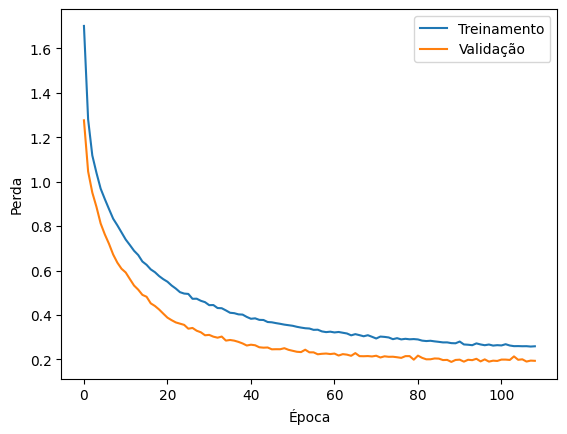

In [25]:
import matplotlib.pyplot as plt
# Visualizar a perda durante o treinamento

plt.plot(history['loss'])
plt.plot(history['val_loss'])

#plt.title('Training Loss')
plt.ylabel('Perda')
plt.xlabel('Época')
plt.legend(['Treinamento', 'Validação'], loc='upper right')
plt.show()

### 7 - Desenhando o gráfico da função de acurácia

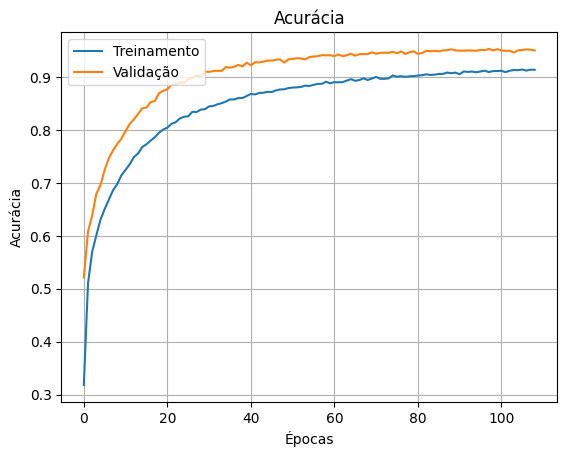

In [26]:
# Gráfico de treinamento e validação da acurácia
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Acurácia')
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.grid(True)
plt.show()
plt.close()

In [20]:
preds = modelo_carregado.predict(X_test)



180/180 [==============================] - 234s 1s/step


### 8 - Função para construção da matriz de confusão

In [29]:
def plot_confusion_matrix(
        cm,
        classes,
        normalize=False,
        title='Confusion matrix',
        cmap=plt.cm.Blues
    ):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Classe real')
    plt.xlabel('Classe predita')

#### 8.1 - Gráfico da matriz de confusão

Confusion matrix, without normalization
[[ 686    2   24   10   20   37    7]
 [   5   84    3    0    0    2    0]
 [  33    4  695   12   28   36   26]
 [  28    1   20 1323   53   21   20]
 [  34    0   26   25  796   61    4]
 [  32    1   52   26   58  814    7]
 [   5    2   20    7    4    7  581]]


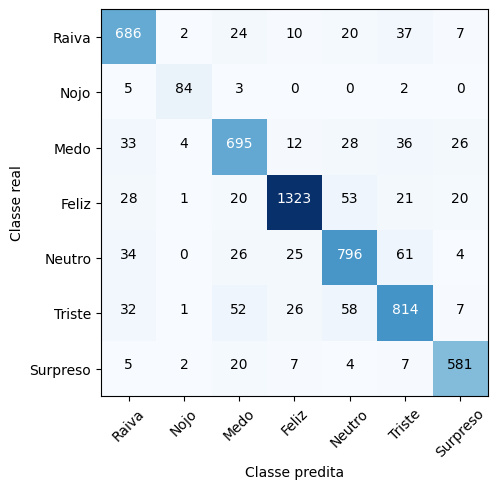

In [30]:
y_test_ = [np.argmax(x) for x in y_test]
preds_ = [np.argmax(x) for x in preds]

cm = confusion_matrix(y_test_, preds_)
plot_confusion_matrix(cm, classes=['Raiva', 'Nojo', 'Medo', 'Feliz', 'Neutro', 'Triste', 'Surpreso'], title='Confusion matrix')
plt.show()
plt.close()

### 9 - Avaliando o modelo com métricas

In [23]:
# Calcular acurácia
accuracy = accuracy_score(y_test_, preds_)
print("Acurácia:", accuracy*float(100.0), "%")

# Calcular precisão
precision = precision_score(y_test_, preds_, average='macro')
print("Precisão:", precision*float(100.0), "%")

# Calcular recall
recall = recall_score(y_test_, preds_, average='macro')
print("Recall:", recall*float(100.0), "%")

# Calcular F1 score
f1 = f1_score(y_test_, preds_, average='macro')
print("F1-score:", f1*float(100.0), "%")

Acurácia: 86.71194705677465 %
Precisão: 86.58043518523438 %
Recall: 87.0564917643138 %
F1-score: 86.80159534175642 %


### 10 - Resultado das predições

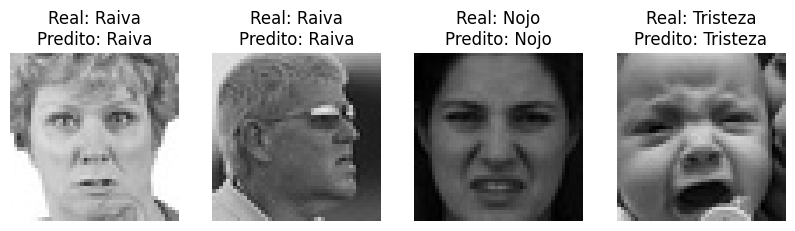

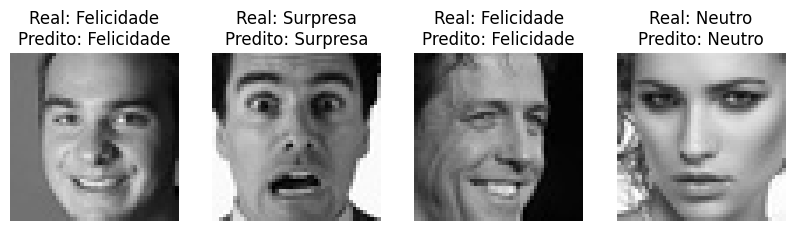

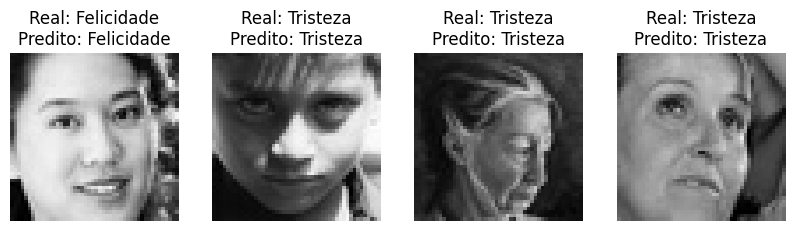

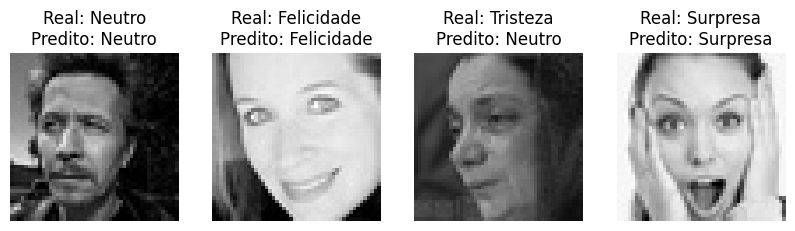

In [37]:
n = 4
for t in range(4):
    plt.figure(figsize=(10,10))
    for i in range(n*t, n*(t+1)):
        plt.subplot(1, n, i + 1 - n*t)
        plt.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB), cmap='gray')
        plt.title('Real: {}\nPredito: {}'.format(classes[np.argmax(y_test[i])], classes[np.argmax(preds[i])]))
        plt.axis('off')
    plt.show()